In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [83]:
print(f"Размер обучающего набора: {train_df.shape}")
print(f"Размер тестового набора: {test_df.shape}")

Размер обучающего набора: (891, 12)
Размер тестового набора: (418, 11)


In [84]:
test_ids = test_df['PassengerId']

In [85]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


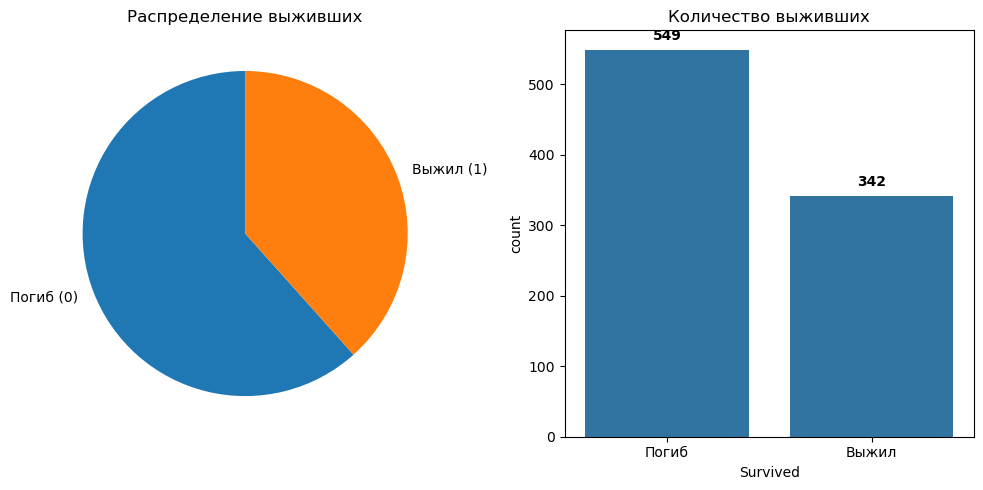

In [86]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
survival_counts = train_df['Survived'].value_counts()
plt.pie(survival_counts, labels=['Погиб (0)', 'Выжил (1)'], startangle=90)
plt.title('Распределение выживших')

plt.subplot(1, 2, 2)
sns.countplot(data=train_df, x='Survived')
plt.title('Количество выживших')
plt.xticks([0, 1], ['Погиб', 'Выжил'])
for i, count in enumerate(survival_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [87]:
print(f"Выжило: {survival_counts[1]} ({survival_counts[1]/len(train_df)*100:.1f}%)")
print(f"Погибло: {survival_counts[0]} ({survival_counts[0]/len(train_df)*100:.1f}%)")

Выжило: 342 (38.4%)
Погибло: 549 (61.6%)


In [88]:
missing_train = train_df.isnull().sum()
missing_test = test_df.isnull().sum()

In [89]:
missing_df = pd.DataFrame({
    'Train_Missing': missing_train,
    'Train_Percent': (missing_train / len(train_df)) * 100,
    'Test_Missing': missing_test,
    'Test_Percent': (missing_test / len(test_df)) * 100
})

print(missing_df[missing_df['Train_Missing'] > 0])

          Train_Missing  Train_Percent  Test_Missing  Test_Percent
Age                 177      19.865320          86.0     20.574163
Cabin               687      77.104377         327.0     78.229665
Embarked              2       0.224467           0.0      0.000000


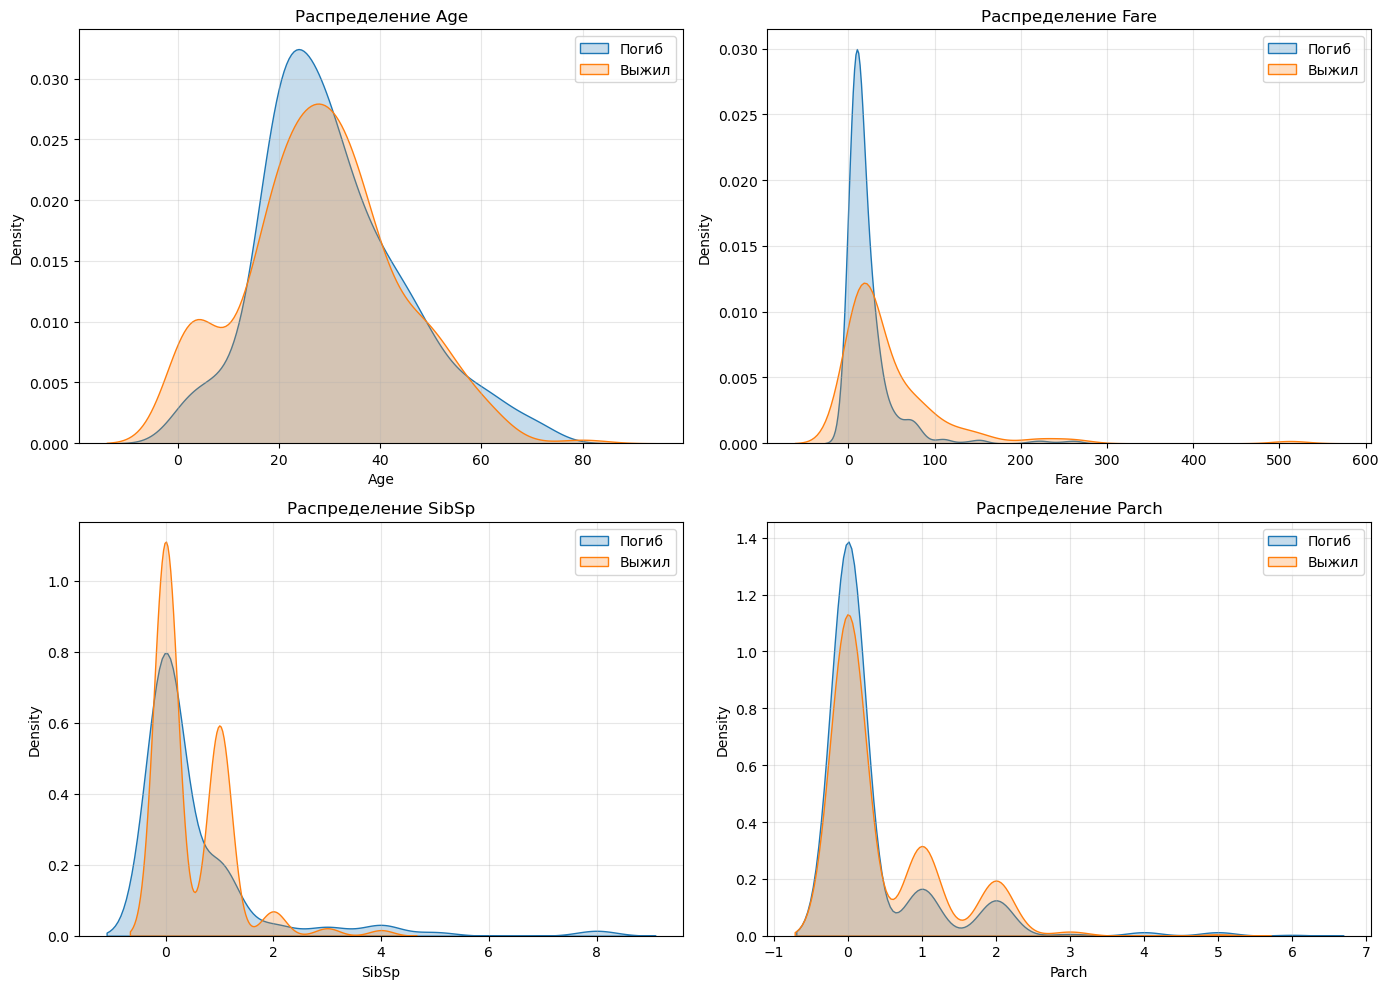

In [90]:
numeric_features = ['Age', 'Fare', 'SibSp', 'Parch']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    for survival in [0, 1]:
        subset = train_df[train_df['Survived'] == survival][feature].dropna()
        sns.kdeplot(subset, label=f'Выжил={survival}', ax=axes[i], fill=True)
    
    axes[i].set_title(f'Распределение {feature}')
    axes[i].set_xlabel(feature)
    axes[i].legend(['Погиб', 'Выжил'])
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

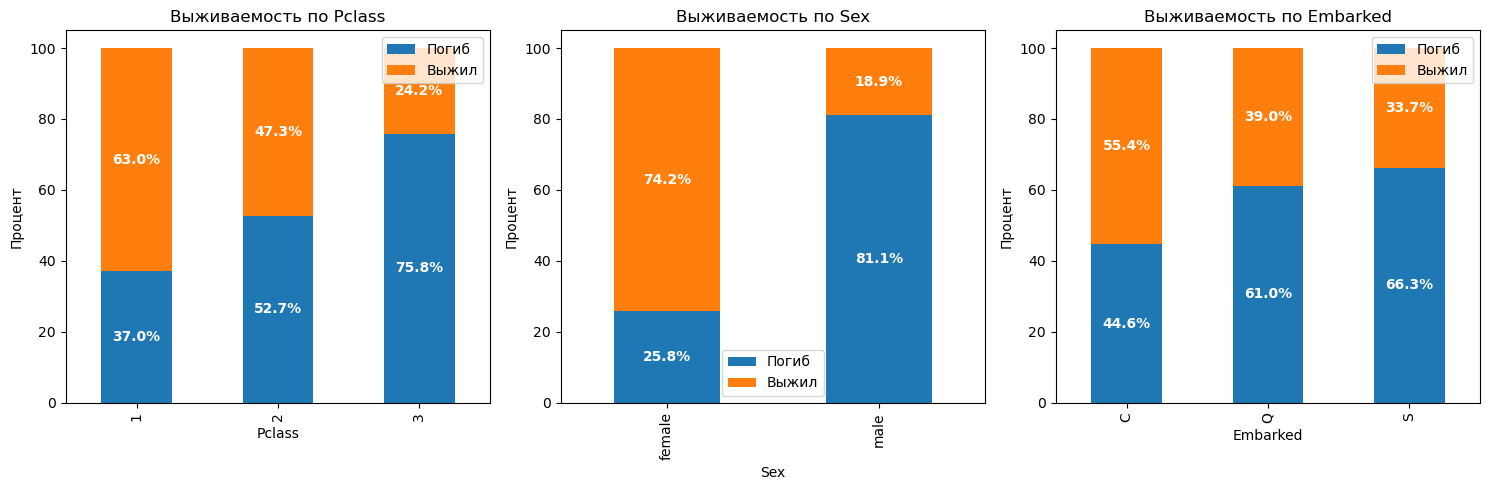

In [91]:
categorical_features = ['Pclass', 'Sex', 'Embarked']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, feature in enumerate(categorical_features):
    cross_tab = pd.crosstab(train_df[feature], train_df['Survived'], normalize='index') * 100
    

    cross_tab.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'Выживаемость по {feature}')
    axes[i].set_ylabel('Процент')
    axes[i].legend(['Погиб', 'Выжил'])
    

    for n, (idx, row) in enumerate(cross_tab.iterrows()):
        cumulative = 0
        for j, val in enumerate(row):
            if val > 5:
                axes[i].text(n, cumulative + val/2, f'{val:.1f}%', 
                           ha='center', va='center', color='white', fontweight='bold')
            cumulative += val

plt.tight_layout()
plt.show()

In [120]:
def enhanced_feature_engineering(df, is_train=True):

    df = df.copy()
    
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    rare_titles = ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
    df['Title'] = df['Title'].replace(rare_titles, 'Rare')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    

    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    df['Title'] = df['Title'].map(title_mapping).fillna(0).astype(int)

    age_medians = df.groupby(['Pclass', 'Title'])['Age'].transform('median')
    df['Age'] = df['Age'].fillna(age_medians)

    df['Age'] = df['Age'].fillna(df['Age'].median())

    df['IsChild'] = (df['Age'] <= 12).astype(int)
    
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    if 'Fare' in df.columns:
        df['Fare'] = df['Fare'].fillna(df['Fare'].median())
        df['FareLog'] = np.log1p(df['Fare'])
    
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1}).astype(int)
    
    embarked_series = df['Embarked'].copy()
    embarked_series = embarked_series.fillna('S')
    embarked_series = embarked_series.map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    df['Embarked'] = embarked_series

    df['SocialStatus'] = df['Pclass'] * df['Fare']
    
    df['FarePerPerson'] = df['Fare'] / df['FamilySize'].replace(0, 1)
    

    df['AgeGroup'] = pd.cut(df['Age'], 
                           bins=[0, 12, 18, 30, 50, 100], 
                           labels=[1, 2, 3, 4, 5]).astype(float)
    
    df['Deck'] = df['Cabin'].astype(str).str[0]
    df['Deck'] = df['Deck'].replace('n', 'U')  # 'n' from NaN
    deck_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8, 'U': 0}
    df['Deck'] = df['Deck'].map(deck_mapping).fillna(0).astype(int)
    df['HasCabin'] = (df['Cabin'].notna()).astype(int)


    cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    for col in cols_to_drop:
        if col in df.columns:
            df = df.drop(col, axis=1)
    

    for col in df.columns:
        if df[col].isnull().any():
            if df[col].dtype.kind in 'iufc':  # Числовые колонки
                df[col] = df[col].fillna(df[col].median())
            else:
                df[col] = df[col].fillna(df[col].mode()[0])
    
    return df


train_processed = enhanced_feature_engineering(train_df)
test_processed = enhanced_feature_engineering(test_df)


print("Колонки в train:", train_processed.columns.tolist())
print("Колонки в test:", test_processed.columns.tolist())


missing_in_test = set(train_processed.columns) - set(test_processed.columns)
missing_in_train = set(test_processed.columns) - set(train_processed.columns)

if missing_in_test:
    print(f"\nДобавляем недостающие колонки в test: {missing_in_test}")
    for col in missing_in_test:
        test_processed[col] = 0

if missing_in_train:
    print(f"Удаляем лишние колонки из test: {missing_in_train}")
    test_processed = test_processed.drop(list(missing_in_train), axis=1)


test_processed = test_processed[train_processed.columns]

Колонки в train: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'IsChild', 'FamilySize', 'IsAlone', 'FareLog', 'SocialStatus', 'FarePerPerson', 'AgeGroup', 'Deck', 'HasCabin']
Колонки в test: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'IsChild', 'FamilySize', 'IsAlone', 'FareLog', 'SocialStatus', 'FarePerPerson', 'AgeGroup', 'Deck', 'HasCabin']

Добавляем недостающие колонки в test: {'Survived'}


In [94]:
if 'Survived' not in train_processed.columns and 'Survived' in train_df.columns:
    train_processed['Survived'] = train_df['Survived'].values

In [95]:
if 'Survived' in train_processed.columns:
    X = train_processed.drop('Survived', axis=1)
    y = train_processed['Survived']
else:
    print("ОШИБКА: Столбец Survived отсутствует в train_processed")
    X = train_processed
    y = train_df['Survived']

In [96]:
X_test_final = test_processed.copy()

In [97]:
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"X_test_final shape: {X_test_final.shape}")

X shape: (891, 17), y shape: (891,)
X_test_final shape: (418, 18)


In [98]:
print("\nПроверка совпадения признаков:")
print(f"Колонки X: {list(X.columns)}")
print(f"Колонки X_test_final: {list(X_test_final.columns)}")


Проверка совпадения признаков:
Колонки X: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'IsChild', 'FamilySize', 'IsAlone', 'FareLog', 'SocialStatus', 'FarePerPerson', 'AgeGroup', 'Deck', 'HasCabin']
Колонки X_test_final: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'IsChild', 'FamilySize', 'IsAlone', 'FareLog', 'SocialStatus', 'FarePerPerson', 'AgeGroup', 'Deck', 'HasCabin']


In [99]:
missing_in_test = set(X.columns) - set(X_test_final.columns)
missing_in_train = set(X_test_final.columns) - set(X.columns)

In [100]:
if missing_in_test:
    print(f"Признаки, отсутствующие в test: {missing_in_test}")
    for col in missing_in_test:
        X_test_final[col] = 0

In [101]:
if missing_in_train:
    print(f"Признаки, отсутствующие в train: {missing_in_train}")
    # Удаляем лишние колонки из test
    X_test_final = X_test_final.drop(list(missing_in_train), axis=1)

Признаки, отсутствующие в train: {'Survived'}


In [102]:
X_test_final = X_test_final[X.columns]

In [103]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [104]:
print(f"\nРазделение данных:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")


Разделение данных:
X_train: (712, 17), y_train: (712,)
X_val: (179, 17), y_val: (179,)


In [105]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_final)

In [106]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nРазделение данных:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")


Разделение данных:
X_train: (712, 17), y_train: (712,)
X_val: (179, 17), y_val: (179,)


In [107]:
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [108]:
knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    knn_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

In [109]:
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [110]:
print(f"Лучшие параметры KNN: {knn_grid.best_params_}")


Лучшие параметры KNN: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}


In [111]:
best_knn = knn_grid.best_estimator_
y_val_pred_knn = best_knn.predict(X_val_scaled)

knn_accuracy = accuracy_score(y_val, y_val_pred_knn)
print(f"Точность KNN на валидации: {knn_accuracy:.4f}")

Точность KNN на валидации: 0.7933


In [112]:
tree_param_grid = {
    'max_depth': [3, 5, 7, 9, 11, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

In [113]:
tree_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    tree_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

In [114]:
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 9, 11, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [115]:
print(f"Лучшие параметры Decision Tree: {tree_grid.best_params_}")
print(f"Лучшая точность (кросс-валидация): {tree_grid.best_score_:.4f}")


Лучшие параметры Decision Tree: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Лучшая точность (кросс-валидация): 0.8217


In [116]:
best_tree = tree_grid.best_estimator_
y_val_pred_tree = best_tree.predict(X_val)

tree_accuracy = accuracy_score(y_val, y_val_pred_tree)
print(f"Точность Decision Tree на валидации: {tree_accuracy:.4f}")

Точность Decision Tree на валидации: 0.7989


In [117]:
accuracies = {
    'KNN': knn_accuracy,
    'Decision Tree': tree_accuracy
}

best_model_name = max(accuracies, key=accuracies.get)
print(f"Лучшая модель: {best_model_name} с точностью {accuracies[best_model_name]:.4f}")

Лучшая модель: Decision Tree с точностью 0.7989


In [118]:
if best_model_name == 'KNN':
    X_scaled = scaler.fit_transform(X)
    best_knn.fit(X_scaled, y)
    X_test_scaled = scaler.transform(X_test_final)
    final_predictions = best_knn.predict(X_test_scaled)
    
elif best_model_name == 'Decision Tree':
    best_tree.fit(X, y)
    final_predictions = best_tree.predict(X_test_final)
    
else: 
    X_scaled = scaler.fit_transform(X)
    best_knn.fit(X_scaled, y)
    best_tree.fit(X, y)
    

    test_proba_knn = best_knn.predict_proba(scaler.transform(X_test_final))
    test_proba_tree = best_tree.predict_proba(X_test_final)
    

    ensemble_proba = best_weights[0] * test_proba_knn + best_weights[1] * test_proba_tree
    final_predictions = np.argmax(ensemble_proba, axis=1)

In [119]:
submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Survived': final_predictions.astype(int)
})


submission_file = 'titanic_predictions.csv'
submission.to_csv(submission_file, index=False)
print(f"\nПредсказания сохранены в файл: {submission_file}")


Предсказания сохранены в файл: titanic_predictions.csv
